<a href="https://colab.research.google.com/github/beyzoskaya/machineLearning_CS454/blob/main/homeworks/convolutionalAutoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import random_split


In [173]:
from torchvision.datasets import FashionMNIST

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, resize_transform=None, target_transform=None):
        self.data = data
        self.resize_transform = resize_transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]

        if self.target_transform:
            original_image = self.target_transform(image)

        if self.resize_transform:
            resized_image = self.resize_transform(image)

        return resized_image, original_image,label


In [174]:
resize_transform = transforms.Compose([
    transforms.Resize((7,7)),
    transforms.ToTensor(),
])

target_transform_train = transforms.Compose([
  transforms.ToTensor(),
])

target_transform_test = transforms.Compose([
    transforms.ToTensor(),
])


In [175]:
train_dataset_original = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset_original  = torchvision.datasets.FashionMNIST(root='data', train=False, download=True)


In [176]:
train_dataset = CustomDataset(train_dataset_original,resize_transform=resize_transform, target_transform=target_transform_train)
test_dataset = CustomDataset(test_dataset_original, resize_transform=resize_transform, target_transform=target_transform_test)


In [177]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [178]:
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])


In [179]:
len(validation_dataset)

12000

In [180]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Resized Images:


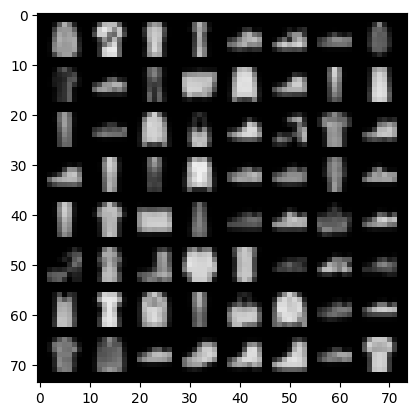

Original Images:


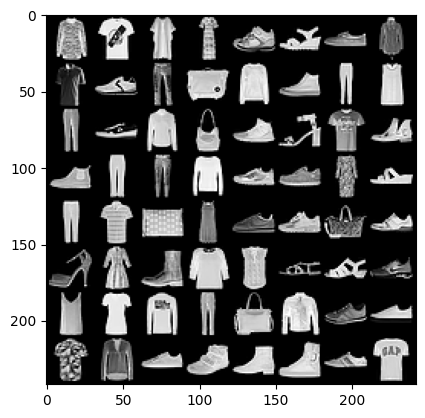

In [181]:
import matplotlib.pyplot as plt

def imshow(img):
    # if using normalization in transforms, you may need to normalize
    # img = img / 2 + 0.5  # unnormalize if you used normalization in your transforms
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
resized_images, original_images, labels = next(dataiter)

# Show images
print("Resized Images:")
imshow(torchvision.utils.make_grid(resized_images))
print("Original Images:")
imshow(torchvision.utils.make_grid(original_images))


Resized Images:


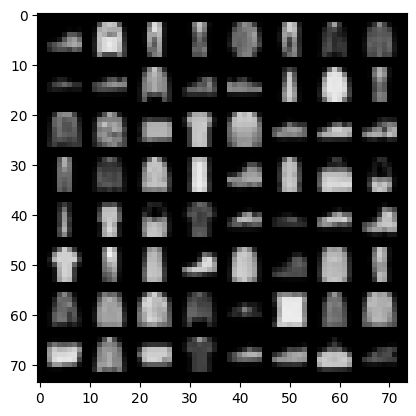

Original Images:


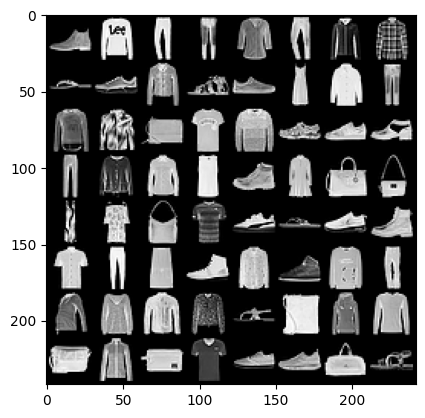

In [182]:
def imshow_test(img):
    # if using normalization in transforms, you may need to normalize
    # img = img / 2 + 0.5  # unnormalize if you used normalization in your transforms
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(test_loader)
resized_images, original_images, labels = next(dataiter)

# Show images
print("Resized Images:")
imshow_test(torchvision.utils.make_grid(resized_images))
print("Original Images:")
imshow_test(torchvision.utils.make_grid(original_images))


Resized Images:


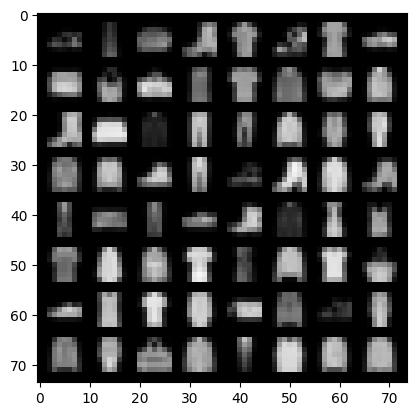

Original Images:


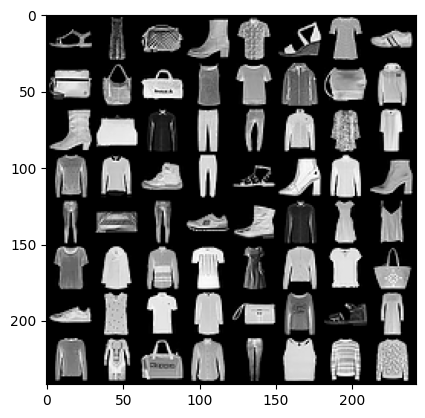

In [183]:
def imshow_val(img):
    # if using normalization in transforms, you may need to normalize
    # img = img / 2 + 0.5  # unnormalize if you used normalization in your transforms
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(validation_loader)
resized_images, original_images, labels = next(dataiter)

# Show images
print("Resized Images:")
imshow_val(torchvision.utils.make_grid(resized_images))
print("Original Images:")
imshow_val(torchvision.utils.make_grid(original_images))


In [184]:
len(train_loader), len(validation_loader), len(test_loader)

(750, 188, 157)

In [185]:
for batch in train_loader:
    resized_images, original_images, labels = batch

    # Print the shape of the resized images
    print("Shape of resized images:", resized_images.shape)

    # Print the shape of the original images
    print("Shape of original images:", original_images.shape)

    # Print the labels
    print("Labels:", labels)

    # Break the loop after the first batch
    break


Shape of resized images: torch.Size([64, 1, 7, 7])
Shape of original images: torch.Size([64, 1, 28, 28])
Labels: tensor([0, 2, 7, 9, 3, 0, 0, 9, 0, 4, 2, 7, 3, 9, 9, 5, 5, 6, 7, 6, 0, 6, 0, 7,
        1, 6, 3, 2, 2, 0, 5, 5, 9, 9, 3, 3, 0, 3, 4, 1, 6, 6, 1, 9, 0, 3, 3, 2,
        8, 3, 9, 5, 4, 2, 2, 8, 4, 3, 4, 0, 1, 8, 2, 1])


In [186]:
label_classes = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

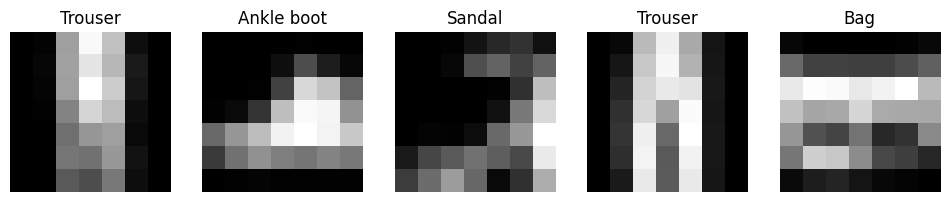

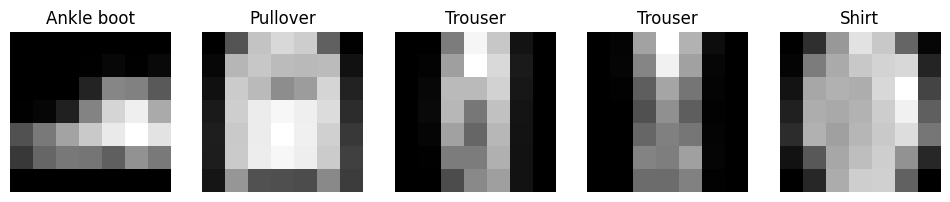

In [187]:
import matplotlib.pyplot as plt

def show_images(dataloader, num_images=5):

    for resized_images, original_images, labels in dataloader:
        resized_images = resized_images[:num_images]
        labels = labels[:num_images]

        plt.figure(figsize=(12, 6))

        for i, (image, label) in enumerate(zip(resized_images, labels)):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image.permute(1, 2, 0).numpy().squeeze(), cmap='gray')
            plt.title(f"{label_classes[label.item()]}")
            plt.axis('off')

        plt.show()
        break

show_images(train_loader)
show_images(test_loader)

In [188]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=1, padding=0),  # 7x7 -> 5x5
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten(start_dim=1)
        # Adjust the number of input features to match the output of the last conv layer
        self.encoder_lin = nn.Sequential(
            nn.Linear(16 * 5 * 5, encoded_space_dim),  # 16 --> last conv layer, 5--> 5x5 last conv dimension
            nn.ReLU(True)
        )

    def forward(self, x):
        #print(f"Shape initially inside encoder: {x.shape}")
        x = self.encoder_cnn(x)
        #print(f"Shape after encoder cnn: {x.shape}")
        x = self.flatten(x)
        #print(f"Shape after flatten: {x.shape}")
        x = self.encoder_lin(x)
        #print(f"Shape after encoder linear: {x.shape}")
        return x


In [189]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Linear(encoded_space_dim, 16 * 5 * 5)
        self.unflatten = nn.Unflatten(1, (16, 5, 5))

        # [5x5] to [7x7]
        self.upconv1 =nn.Sequential(
          nn.ConvTranspose2d(16,16, kernel_size=3, stride=1, padding=0),
          nn.ReLU(True)
        )
        self.upconv2 = nn.Sequential(
          nn.ConvTranspose2d(16,8,kernel_size=3, stride=1, padding=1),
          nn.ReLU(True)
        )
        self.upconv3 = nn.Sequential(
          nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
          nn.ReLU(True)
        )
        self.final_conv = nn.Sequential(
          nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2, padding=1),
          nn.ReLU(True)
        )

    def forward(self, x):
        #print(f"Shape initially inside decoder: {x.shape}")
        x = self.decoder_lin(x)
        #print(f"Shape after decoder linear: {x.shape}")
        x = self.unflatten(x)
        #print(f"Shape after unflatten: {x.shape}")

        x = self.upconv1(x)
        #print(f"Shape after first convolutional: {x.shape}")
        x = self.upconv2(x)
        #print(f"Shape after second conv: {x.shape}")
        x = self.upconv3(x)
        #print(f"Shape after third conv: {x.shape}")
        x = self.final_conv(x)
        #print(f"Shape after final conv: {x.shape}")
        #x = torch.sigmoid(x)

        #print(f"Shape after sigmoid: {x.shape}")
        return x


In [190]:
class EncoderWithOneConv(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        # self.encoder_cnn = nn.Sequential(
        #     nn.Conv2d(1, 8, 3, stride=1, padding=1),  # 7x7 -> 7x7
        #     nn.ReLU(True),
        #     nn.Conv2d(8, 16, 3, stride=1, padding=0),  # 7x7 -> 5x5
        #     nn.ReLU(True),
        #     nn.Conv2d(16, 16, 3, stride=1, padding=1),  # New Convolutional Layer
        #     nn.ReLU(True),
        # )

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),
            nn.ReLU(True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=1, padding=0),
            nn.ReLU(True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(True),
        )

        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(16 * 5 * 5, encoded_space_dim),
            nn.ReLU(True)
        )

    def forward(self, x):
        #print(f"Shape initially inside encoder: {x.shape}")
        x = self.conv1(x)
        #print(f"Shape after conv1: {x.shape}")
        x = self.conv2(x)
        #print(f"Shape after conv2: {x.shape}")
        x = self.conv3(x)
        #print(f"Shape after conv3: {x.shape}")
        x = self.flatten(x)
        #print(f"Shape after flatten: {x.shape}")
        x = self.encoder_lin(x)
        #print(f"Shape after linear: {x.shape}")
        return x


class DecoderForOneConv(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Linear(encoded_space_dim, 16 * 5 * 5)
        self.unflatten = nn.Unflatten(1, (16, 5, 5))

        # [5x5] to [7x7]
        self.upconv1 =nn.Sequential(
          nn.ConvTranspose2d(16,16, kernel_size=3, stride=1, padding=0),
          nn.ReLU(True)
        )
        self.upconv2 = nn.Sequential(
          nn.ConvTranspose2d(16,8,kernel_size=3, stride=1, padding=1),
          nn.ReLU(True)
        )
        self.upconv3 = nn.Sequential(
          nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
          nn.ReLU(True)
        )
        self.final_conv = nn.Sequential(
          nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2, padding=1),
          nn.ReLU(True)
        )

    def forward(self, x):
        #print(f"Shape initially inside decoder: {x.shape}")
        x = self.decoder_lin(x)
        #print(f"Shape after decoder linear: {x.shape}")
        x = self.unflatten(x)
        #print(f"Shape after unflatten: {x.shape}")

        x = self.upconv1(x)
        #print(f"Shape after first convolutional: {x.shape}")
        x = self.upconv2(x)
        #print(f"Shape after second conv: {x.shape}")
        x = self.upconv3(x)
        #print(f"Shape after third conv: {x.shape}")
        x = self.final_conv(x)
        #print(f"Shape after final conv: {x.shape}")
        #x = torch.sigmoid(x)

        #print(f"Shape after sigmoid: {x.shape}")
        return x


In [191]:
class EncoderForDecoderWithOneConvAdditional(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=1, padding=0),  # 7x7 -> 5x5
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten(start_dim=1)
        # Adjust the number of input features to match the output of the last conv layer
        self.encoder_lin = nn.Sequential(
            nn.Linear(16 * 5 * 5, encoded_space_dim),  # 16 --> last conv layer, 5--> 5x5 last conv dimension
            nn.ReLU(True)
        )

    def forward(self, x):
        print(f"Shape initially inside encoder: {x.shape}")
        x = self.encoder_cnn(x)
        print(f"Shape after encoder cnn: {x.shape}")
        x = self.flatten(x)
        print(f"Shape after flatten: {x.shape}")
        x = self.encoder_lin(x)
        print(f"Shape after encoder linear: {x.shape}")
        return x



class DecoderWithOneConv(nn.Module):
    def __init__(self, encoded_space_dim):
        super(DecoderWithOneConv, self).__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 16 * 5 * 5),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(1, (16, 5, 5))

        self.upconv1 =nn.Sequential(
          nn.ConvTranspose2d(16,16, kernel_size=3, stride=1, padding=0),
          nn.ReLU(True)
        )
        self.upconv2 = nn.Sequential(
          nn.ConvTranspose2d(16,8,kernel_size=3, stride=1, padding=1),
          nn.ReLU(True)
        )
        self.upconv3 = nn.Sequential(
          nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
          nn.ReLU(True)
        )

        # Additional convolutional layer without changing spatial dimensions
        self.upconv4 = nn.Sequential(
            nn.ConvTranspose2d(4, 4, kernel_size=3, stride=1, padding=1),  # Adjust parameters
            nn.ReLU(True)
        )


        self.upconv5 = nn.Sequential(
            nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True)
        )


    def forward(self, x):
        x = self.decoder_lin(x)
        print(f"Shape after decoder linear: {x.shape}")
        x = self.unflatten(x)
        print(f"Shape after unflatten: {x.shape}")
        x = self.upconv1(x)
        print(f"Shape after conv1: {x.shape}")
        x = self.upconv2(x)
        print(f"Shape after conv2: {x.shape}")
        x = self.upconv3(x)
        print(f"Shape after conv3: {x.shape}")

        x = self.upconv4(x)
        print(f"Shape after conv4: {x.shape}")
        x = self.upconv5(x)
        print(f"Shape after conv5: {x.shape}")

        return x


In [192]:
class Encoder_3(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=1, padding=0),  # 7x7 -> 5x5
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten(start_dim=1)
        # Adjust the number of input features to match the output of the last conv layer
        self.encoder_lin = nn.Sequential(
            nn.Linear(16 * 5 * 5, encoded_space_dim),  # 16 --> last conv layer, 5--> 5x5 last conv dimension
            nn.ReLU(True)
        )

    def forward(self, x):
        #print(f"Shape initially inside encoder: {x.shape}")
        x = self.encoder_cnn(x)
        #print(f"Shape after encoder cnn: {x.shape}")
        x = self.flatten(x)
        #print(f"Shape after flatten: {x.shape}")
        x = self.encoder_lin(x)
        #print(f"Shape after encoder linear: {x.shape}")
        return x

class Decoder_3(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32 * 7 * 7),  # Adjust the size to match encoder output
            nn.ReLU(True)
        )
        self.unflatten = nn.Unflatten(1, (32, 7, 7))

        # Upsampling layers to increase spatial dimensions
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True)
        )  # 7x7 -> 14x14
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True)
        )  # 14x14 -> 28x28
        self.final_conv = nn.Sequential(
            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True)
        )  # 28x28

    def forward(self, x):
        #print(f"Shape initially inside decoder: {x.shape}")
        x = self.decoder_lin(x)
        #print(f"Shape after decoder linear: {x.shape}")
        x = self.unflatten(x)
        #print(f"Shape after unflatten decoder: {x.shape}")
        x = self.upconv1(x)
        #print(f"Shape after conv1: {x.shape}")
        x = self.upconv2(x)
        #print(f"Shape after conv2: {x.shape}")
        x = self.final_conv(x)
        #print(f"Shape after final conv: {x.shape}")
        return x



In [193]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results

### Initialize the two networks
d = 32

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder_1 = Encoder(encoded_space_dim=d)
decoder_1 = Decoder(encoded_space_dim=d)

encoder_2 = EncoderWithOneConv(encoded_space_dim=d)
decoder_2 = DecoderForOneConv(encoded_space_dim=d)

encoder_3 = Encoder_3(encoded_space_dim=d)
decoder_3 = Decoder_3(encoded_space_dim=d)

models = [
    {'encoder': encoder_1, 'decoder': decoder_1},
    {'encoder': encoder_2, 'decoder': decoder_2},
    {'encoder': encoder_3, 'decoder': decoder_3},
]

optimizers = []
params_to_optimize = []
# params_to_optimize = [
#     {'params': encoder.parameters()},
#     {'params': decoder.parameters()}
# ]

for i,model in enumerate(models):
  encoder_i = model['encoder']
  decoder_i = model['decoder']

  optimizer_i = torch.optim.Adam(list(encoder_i.parameters()) + list(decoder_i.parameters()), lr=lr)
  optimizers.append(optimizer_i)
  params_to_optimize.extend(list(encoder_i.parameters()) + list(decoder_i.parameters()))
optimizer = torch.optim.Adam(params_to_optimize, lr=lr)


In [194]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
#encoder_1.to(device)
#decoder_1.to(device)
for model in models:
  model['encoder'].to(device)
  model['decoder'].to(device)

Selected device: cpu


In [195]:
def train_epoch(encoder,decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    #encoder.train()
    #decoder.train()
    #train_loss = []

    for model in models:
      print(f"Model encoder: {model['encoder']}")
      print(f"Model decoder: {model['decoder']}")
      model['encoder'].train()
      model['decoder'].train()


    train_loss = []

    # Iterate the dataloader
    for resized_image, original_image, _ in dataloader:
        # Move tensor to the proper device
        resized_image = resized_image.to(device)
        #print(f"Shape for resized image: {resized_image.shape}")
        original_image = original_image.to(device)
        #print(f"Shape for original image: {original_image.shape}")

        losses = []

        for model, optimizer in zip(models,optimizers):
          encoder_i = model['encoder']
          decoder_i = model['decoder']

          # Encode data
          encoded_data = encoder_i(resized_image)

          # Decode data
          decoded_data = decoder_i(encoded_data)

          # Evaluate loss
          loss = loss_fn(decoded_data, original_image)

          # Backward pass
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          losses.append(loss.detach().cpu().numpy())

        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        print('\t partial train loss (single batch):', losses)

        train_loss.extend(losses)

    return np.mean(train_loss)


In [196]:
# def test_epoch(encoder, decoder, device, dataloader, loss_fn):

#     # Set evaluation mode for encoder and decoder
#     encoder.eval()
#     decoder.eval()
#     with torch.no_grad():  # No need to track the gradients
#         # Define the lists to store the outputs and labels for each batch
#         conc_out = []
#         conc_original = []

#         # Iterate the dataloader
#         for resized_image, original_image, _ in dataloader:
#             # Move tensor to the proper device
#             resized_image = resized_image.to(device)
#             #print(f"Shape for resized image: {resized_image.shape}")
#             original_image = original_image.to(device)
#             #print(f"Shape for original image: {original_image.shape}")

#             # Encode and Decode data
#             encoded_data = encoder(resized_image)
#             decoded_data = decoder(encoded_data)

#             # Append the decoded data and the original image to the lists
#             conc_out.append(decoded_data.cpu())
#             conc_original.append(original_image.cpu())

#         # Concatenate all the values in the lists
#         conc_out = torch.cat(conc_out)
#         conc_original = torch.cat(conc_original)

#         # Evaluate global loss
#         val_loss = loss_fn(conc_out, conc_original)

#     return val_loss.item()  # Use .item() to get the scalar value of the loss tensor


In [197]:
def test_epoch(encoder,decoder, device, dataloader, loss_fn):
    # Set evaluation mode for all models
    for model in models:
        model['encoder'].eval()
        model['decoder'].eval()

    with torch.no_grad():  # No need to track the gradients
        # Define the lists to store the outputs and labels for each batch
        conc_out = []
        conc_original = []

        # Iterate the dataloader
        for resized_image, original_image, _ in dataloader:
            # Move tensor to the proper device
            resized_image = resized_image.to(device)
            # print(f"Shape for resized image: {resized_image.shape}")
            original_image = original_image.to(device)
            # print(f"Shape for original image: {original_image.shape}")

            losses = []

            # Loop through models
            for model in models:
                encoder_i = model['encoder']
                decoder_i = model['decoder']

                # Encode and Decode data
                encoded_data = encoder_i(resized_image)
                decoded_data = decoder_i(encoded_data)

                # Evaluate loss
                loss = loss_fn(decoded_data, original_image)

                # Append the decoded data and the original image to the lists
                conc_out.append(decoded_data.cpu())
                conc_original.append(original_image.cpu())

                losses.append(loss.item())

            # Print batch loss
            print('\t partial validation loss (single batch):', losses)

    # Concatenate all the values in the lists
    conc_out = torch.cat(conc_out)
    conc_original = torch.cat(conc_original)

    # Evaluate global loss
    val_loss = np.mean(losses)
    print('\t validation loss:', val_loss)

    return val_loss

In [198]:
test_dataset[0][0].shape

torch.Size([1, 7, 7])

In [199]:
train_dataset[0][0].shape

torch.Size([1, 7, 7])

In [200]:
def plot_ae_outputs(encoder, decoder, dataset, n=10):
    plt.figure(figsize=(16, 4.5))

    # Get labels from the dataset
    labels = np.array([dataset[idx][2] for idx in range(len(dataset))])

    # Select indices for plotting
    t_idx = {i: np.where(labels == i)[0][0] for i in range(n)}

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)

        # Extract image and label from the dataset
        img, _, _ = dataset[t_idx[i]]
        img = img.unsqueeze(0).to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img = decoder(encoder(img))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i == n // 2:
            ax.set_title('Original images')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i == n // 2:
            ax.set_title('Reconstructed images')

    plt.show()


In [201]:
# import os

# def plot_losses(train_loss_list, val_loss_list, model_name, save_path=None):
#     plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Train Loss')
#     plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Include model name in the plot title
#     plt.title(f'Losses for Model: {model_name}')

#     if save_path:
#         save_path = os.path.join(os.path.dirname(save_path), f'{model_name}_loss_plot.png')
#         plt.savefig(save_path)
#     else:
#         plt.show()

In [202]:
from prettytable import PrettyTable

def calculate_statistics(models, train_loss_lists, test_loss_lists):
    result_table = PrettyTable()
    result_table.field_names = ["Model", "Parameter Count", "Final Train MSE", "Final Test MSE"]

    for model_idx, (model, train_losses, test_losses) in enumerate(zip(models, train_loss_lists, test_loss_lists)):
        encoder = model['encoder']
        decoder = model['decoder']

        # Calculate parameter count
        total_params = sum(p.numel() for p in encoder.parameters()) + sum(p.numel() for p in decoder.parameters())

        # Get final train and test MSE
        final_train_mse = train_losses[-1]
        final_test_mse = test_losses[-1]

        result_table.add_row([f'Model {model_idx + 1}', total_params, final_train_mse, final_test_mse])

    return result_table

In [203]:
def plot_losses(train_loss_lists, test_loss_lists, model_names, save_path='loss_plot.png'):
    plt.figure(figsize=(10, 6))

    for train_losses, test_losses, model_name in zip(train_loss_lists, test_loss_lists, model_names):
        plt.plot(range(1, num_epochs + 1), train_losses, label=f'Train Loss - {model_name}')
        plt.plot(range(1, num_epochs + 1), test_losses, label=f'Test Loss - {model_name}', linestyle='dashed')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Epochs vs Train/Test MSE for Different Architectures')

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Shape after encoder linear: torch.Size([64, 32])
Shape initially inside decoder: torch.Size([64, 32])
Shape after decoder linear: torch.Size([64, 1568])
Shape after unflatten decoder: torch.Size([64, 32, 7, 7])
Shape after conv1: torch.Size([64, 16, 14, 14])
Shape after conv2: torch.Size([64, 8, 28, 28])
Shape after final conv: torch.Size([64, 1, 28, 28])
	 partial train loss (single batch): [array(0.01310341, dtype=float32), array(0.01369677, dtype=float32), array(0.01105704, dtype=float32)]
Shape initially inside encoder: torch.Size([64, 1, 7, 7])
Shape after encoder cnn: torch.Size([64, 16, 5, 5])
Shape after flatten: torch.Size([64, 400])
Shape after encoder linear: torch.Size([64, 32])
Shape initially inside decoder: torch.Size([64, 32])
Shape after decoder linear: torch.Size([64, 1568])
Shape after unflatten decoder: torch.Size([64, 32, 7, 7])
Shape after conv1: torch.Size([64, 16, 14, 14])
Shape after conv2: torch.Size([64, 8, 28, 2

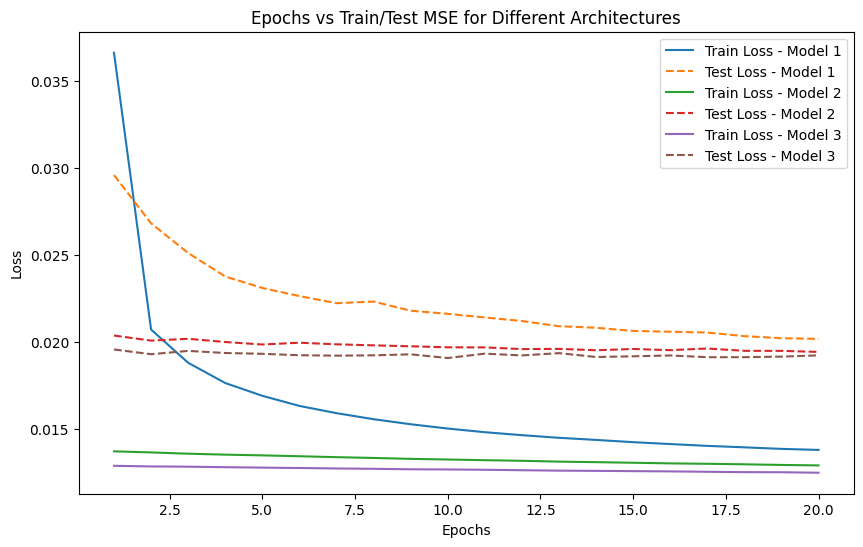

In [204]:
num_epochs = 20
train_loss_lists = []
test_loss_lists = []
model_names = []

# Training Loop
for model_idx, model in enumerate(models):
    encoder = model['encoder']
    decoder = model['decoder']
    optimizer = optimizers[model_idx]

    train_loss_list = []
    test_loss_list = []

    for epoch in range(num_epochs):
        train_loss = train_epoch(encoder,decoder, device, train_loader, loss_fn, optimizer)  # Pass the current model
        test_loss = test_epoch(encoder,decoder, device, test_loader, loss_fn)  # Pass the current model

        print(f'Model {model_idx + 1} | Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss} | Test Loss: {test_loss}')

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

    train_loss_lists.append(train_loss_list)
    test_loss_lists.append(test_loss_list)
    model_names.append(f'Model {model_idx + 1}')


plot_losses(train_loss_lists, test_loss_lists, model_names, save_path='loss_plot.png')
report_table = calculate_statistics(models, train_loss_lists, test_loss_lists)
print(report_table)



In [206]:

# Save trained models
torch.save(encoder_1.state_dict(), "encoder_model1.pth")
torch.save(decoder_1.state_dict(), "decoder_model1.pth")

torch.save(encoder_2.state_dict(), "encoder_model2.pth")
torch.save(decoder_2.state_dict(), "decoder_model2.pth")

torch.save(encoder_3.state_dict(), "encoder_model3.pth")
torch.save(decoder_3.state_dict(), "decoder_model3.pth")


In [208]:
# Load model architecture
encoder = Encoder(encoded_space_dim=d)  # Replace with the correct dimension
decoder = Decoder(encoded_space_dim=d)  # Replace with the correct dimension

# Load the trained state_dict
encoder_state_dict = torch.load("encoder_model1.pth")
decoder_state_dict = torch.load("decoder_model1.pth")

# Load the state_dict into the models
encoder.load_state_dict(encoder_state_dict)
decoder.load_state_dict(decoder_state_dict)

# Set the models to evaluation mode
encoder.eval()
decoder.eval()

real_images = []
reconstructed_images = []

with torch.no_grad():
  for batch in train_loader:
    real_inputs = batch[0]
    real_inputs = real_inputs.to(device)
    encoded = encoder(real_inputs)
    reconstructed = decoder(encoded)
    real_images.append(real_inputs.cpu())
    reconstructed_images.append(reconstructed.cpu())

real_images = torch.cat(real_images, dim=0)
reconstructed_images = torch.cat(reconstructed_images, dim=0)


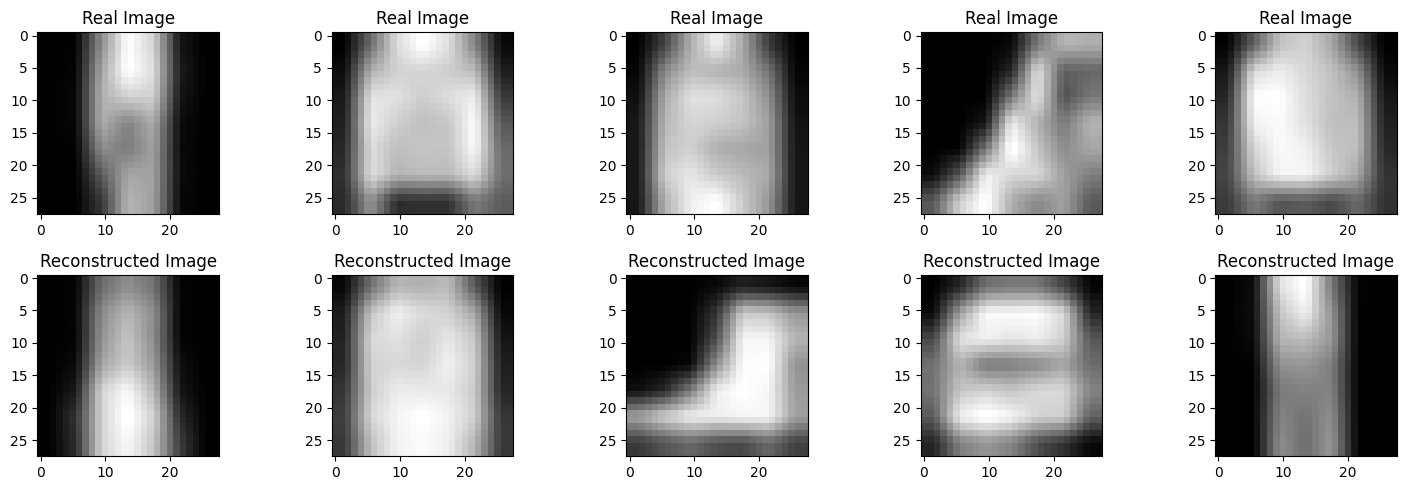

In [210]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define a function to display images
def display_images(images, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i, 0], cmap='gray')  # Assuming grayscale images
        plt.title('Real Image')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(images[i + num_images, 0], cmap='gray')  # Assuming grayscale images
        plt.title('Reconstructed Image')

    plt.tight_layout()
    plt.show()

# Resize real images to match the size of reconstructed images (28x28)
real_images_resized = F.interpolate(real_images, size=(28, 28), mode='bilinear', align_corners=False)

# Display the first 5 real and reconstructed images
display_images(torch.cat((real_images_resized, reconstructed_images), dim=0), num_images=5)
